# Time series forecast by ARIMA, Prophet, Holt-Winters

Data source: https://www.kaggle.com/arashnic/learn-time-series-forecasting-from-gold-price

Description: gold price from 1970-01-01 to 2020-03-13

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#set date as index
df = pd.read_csv('../input/learn-time-series-forecasting-from-gold-price/gold_price_data.csv',index_col='Date', parse_dates=['Date'], dayfirst=False)

In [ ]:
#gold price is not collected in daily basis at the beginning
df.head(10)

In [ ]:
#gold price almost collected in daily basis later
df.tail(10)

In [ ]:
df.shape

In [ ]:
df.isnull().sum()

In [ ]:
df.describe()

In [ ]:
df.plot()

# 

In [ ]:
import matplotlib.pyplot as plt
from pylab import rcParams

In [ ]:
#convert time series to a frequency of year. Original frequency is quarterly
df.asfreq('Y').plot()

In [ ]:
df.asfreq('M').plot()

# Shifting and lags

In [ ]:
#compare time series with a past of itself
plt.plot(df, label='Original')
plt.plot(df.shift(300), label='Lagged')
plt.legend()
plt.show()

In [ ]:
#change in absolute no
df.diff().plot()

In [ ]:
#% change
df.pct_change().plot()

In [ ]:
#approx. interval of first 50 rows is ranged from month to quartar
df[:50].pct_change().plot()

In [ ]:
#data from around 1979 is more completed (daily)
#periods: shift for forming percent change to have briefly monthly %change
df[51:].pct_change(periods=30).plot()

In [ ]:
df[60:]

# Time Series Components

- 3 systematic components: level, trend, seasonality
- 1 non-systematic component: noise

    - Level: average value
    - Trend: increasing/ decreasing value 
    - Seasonality: repeating short-term cycle
    - Noise: random variation

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
rcParams['figure.figsize'] = 6,5

result = seasonal_decompose(df, model='multiplicative', period=120)
result.plot()
plt.show()

# Stationarity
- constant mean
- constant variance
- autocovariance thta does not depend on time

i.e. mean, variance, and autocorrelation do not change with time

2 popular test:
1. Rolling statistics
2. ADCF test

In [ ]:
#original df isn't in fixed frequency, so '365 days' is used instead
rcParams['figure.figsize'] = 10,5
plt.plot(df, label='Original')
plt.plot(df.rolling('365D').mean(), label='Rolling mean')
plt.legend()
plt.show()

In [ ]:
rcParams['figure.figsize'] = 10,5
plt.plot(df, label='Original')
plt.plot(df.expanding().mean(), label='Expanding mean')
plt.plot(df.expanding().std(), label='Expanding std')
plt.legend()
plt.show()

# 1. ARIMA model
- Auto Regressive Integrated Moving Average
- forecast based on past values
- suitable for non-seasonal time series & not a random white noise 
- characterized by 3 terms: d, p, q
    - d: number of differencing required to make the time series stationary
    - p: order of the AR term
    - q: order of the MA term
- time series with seasonal patterns --> need to add seasonal terms --> SARIMA (Seasonal ARIMA)



# Order of differencing (d)

- Objective of differencing: convert the time series into stationary 

(ie. if the time series is already stationary, d=0)

- Method of stationarity determination

ADF test (Augmented Dickey Fuller test) is useful in determining if the series is stationary. ADF is in default of a null hypothesis that series is non-stationary, so if the p-value <0.05 and null hypothesis can be rejected.

python tools for ADF test: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

- Method of converting the stationarity
    - Differencing 
        - stabilise the mean of a time series by removing changes in the level of a time series
        - eliminate/reduce the trend and seasonality
    - Transformations
        logarithms stabilise the variance of a time series

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf(df):
    rcParams['figure.figsize'] = 10,5
    dftest = adfuller(df, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test statistics','p-value','number of lags used','number of observations'])
    #critical values are stored in dictionary format
    for key,value in dftest[4].items():
        adf['Critical values({})'.format(key)] = value
    return adf, df.plot()

In [ ]:
#original series
adf(df)

In [ ]:
#1st order differencing
adf(df.diff().dropna())

In [ ]:
#2nd order differencing
adf(df.diff().diff().dropna())

Both 1st & 2nd order differencing are able to make the seies stationary with p<0.05.

However, it should be careful not to over-difference the series as it may affect the model parameters. 

- Method of determining the right order of differencing
    1. Autocorrelation function plot (ACF plot)
        - Terminalogy
            - autocorrelation: correlation of observations and previous values in the same series
            - lag: observations with previous time steps
        - ACF plot reaches to zero fairly quick --> ideal order of differencing
        - +ve for many lags (>=10), needs further differencing
        - lag 1's autocorrelation too -ve --> probably over-differenced
    - Interpretation
        - confidence intervals (95%) are drawn as a cone
        - correlation values outside the code are likely a correlation, instead of statistical fluke (by luck)
    2. ndiffs() under pmdarima
 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':120})
fig, axes = plt.subplots(3, 1, sharex=True)

plot_acf(df, ax=axes[0])
axes[0].set_title('Original series')

plot_acf(df.diff().dropna(), ax=axes[1])
axes[1].set_title('1st order differencing')

plot_acf(df.diff().diff().dropna(), ax=axes[2])
axes[2].set_title('2nd order differencing')

plt.show()

Lags in 2nd differencing fall into negative zone very quickly, indicating the series may have been over differenced.
Thus, 1st differencing should be chosen.

In [ ]:
pip install pmdarima

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs

There is another method to determine the order of differencing: ndiffs

3 tests can be choosen: ‘kpss’(default), ‘adf’, ‘pp’

http://alkaline-ml.com/pmdarima/1.5.1/modules/generated/pmdarima.arima.ndiffs.html

All tests show the same result: 1

In [ ]:
# ADF Test
ndiffs(df, test='adf')  # 2

# KPSS test
ndiffs(df, test='kpss')  # 0

# PP test:
ndiffs(df, test='pp')  # 2

# Order of  AR term (p)

- Method of finding p
    - Partial Autocorrelation (PACF) plot
        - correlation between the series and its lag excluding the contributions from the intermediate lags

https://i.stack.imgur.com/DjEKh.png

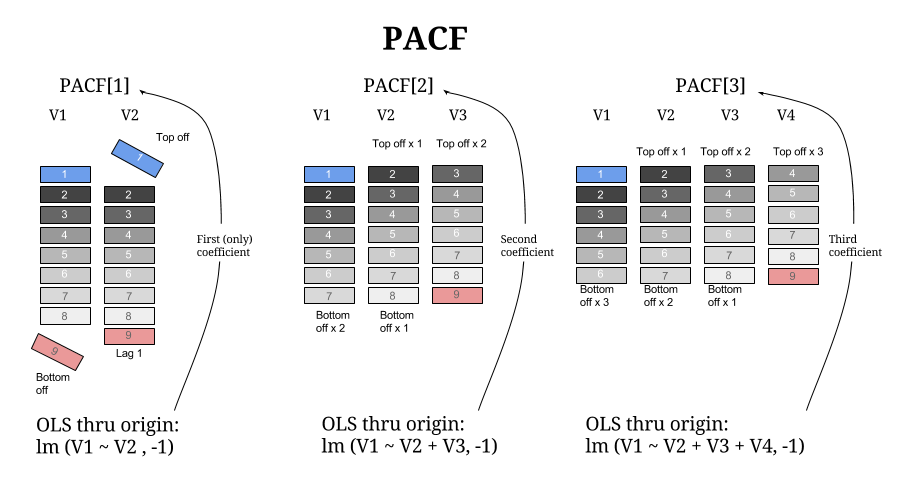

In [ ]:
rcParams['figure.figsize'] = 6,3
plot_pacf(df.diff().dropna())
plt.show()

PACF lag 1 is significant (above the significance line) and lag 2 is insignificant, so p=1 should be chosen.

# Order of MA term (q)

- Definition of MA term (q):
    -  error of the lagged forecast
- Method of finding q
    - ACF
        - show no of MA terms required to remove autocorrelation in a stationarized series

In [ ]:
rcParams['figure.figsize'] = 6,3
plot_acf(df.diff().dropna())
plt.show()

Similar with the result of AR, lag 1 is also far above the significance line than others.

q=1

In [ ]:
model = ARIMA(df, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

The P Values of the AR1 and MA1 terms have improved and are highly significant (< 0.05).

In [ ]:
rcParams['figure.figsize'] = 12,5
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Although residual errors not mainly around zero, but the variance is uniform.

Note: dynamic=False --> in-sample lagged values are used for prediction

In [ ]:
rcParams['figure.figsize'] = 12,5
model_fit.plot_predict(dynamic=False)
plt.show()

# Out-of-Time Cross validation

In [ ]:
df.shape

In [ ]:
#want to verify the recent 3 month-trend
#simply create train-test split that set test size around 90 rows
train = df[:10700]
test = df[10700:]

In [ ]:
#arima(1,1,1)
model_val = ARIMA(train, order=(1,1,1))
model_val_fit = model_val.fit(disp=-1)

In [ ]:
# alpha=0.05 --> 95% conf
fc, se, conf = model_val_fit.forecast(87, alpha=0.05)

In [ ]:
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[10000:], label='Train')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ARIMA(1,1,1) model predict the gold price will drop in next 3 months and the actual price almost lie within the 95% confidence band. However, forecasts are consistently below the actual value. 

So, other parameters should be tried.

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [ ]:
def arima(d,p,q):
    train = df[:10700]
    test = df[10700:]

    model_val = ARIMA(train, order=(d,p,q))
    model_val_fit = model_val.fit(disp=-1)
    print(model_val_fit.summary())

    fc, se, conf = model_val_fit.forecast(87, alpha=0.05)
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[10000:], label='Train')
    plt.plot(test, label='Actual')
    plt.plot(fc_series, label='Forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actual')
    plt.legend(loc='upper left', fontsize=8)
    print('RSME:{}'.format(round(rmse(test, fc_series).mean(),4)))
    return plt.show()

In [ ]:
arima(3,2,1)

ARIMA(3,2,1) makes no difference. Since gold price is flutuating, similar to stock, it may be difficult to forcast a 3-month trend.
Let's predict a shorter period.

In [ ]:
def arima_size(day,d,p,q):
    n = 10787-day
    train = df[:n]
    test = df[n:]

    model_val = ARIMA(train, order=(d,p,q))
    model_val_fit = model_val.fit(disp=-1)

    fc, se, conf = model_val_fit.forecast(day, alpha=0.05)
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[10400:], label='Train')
    plt.plot(test, label='Actual')
    plt.plot(fc_series, label='Forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actual')
    plt.legend(loc='upper left', fontsize=8)
    print('RSME:{}'.format(round(rmse(test, fc_series).mean(),4)))
    return plt.show()

In [ ]:
#predict next 30 days
arima_size(day=30,d=1,p=1,q=1)

In [ ]:
#predict next 10 days
arima_size(day=10,d=1,p=1,q=1)

# Auto Arima Forecast

search multiple combinations of p,d,q parameters in a stepwise approach 
--> choose the best model having the least AIC

In [ ]:
import pmdarima as pm

In [ ]:
train = df[:10757]
test = df[10757:]

In [ ]:
model_auto_val = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # adf test help find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto_val.summary())

ARIMA(2,1,2) is suggested as it has smallest AIC (Akaike information criterio) value.

AIC) is an estimator of prediction error and balance the trade-off between the goodness of fit and simplicity of the model.

In [ ]:
plt.figure(figsize=(12,5), dpi=100)

fitted, confint = model_auto_val.predict(30, return_conf_int=True)

# make series for plotting purpose
auto_series = pd.Series(fitted, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)

plt.plot(train[10400:], label='Train')
plt.plot(test, label='Actual')
plt.plot(auto_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actual in next 30 days')
plt.legend(loc='upper left', fontsize=12)
print('RSME:{}'.format(round(rmse(test, auto_series).mean(),4)))
plt.show()

rmse of ARIMA(2,1,2) is 46.018, while that of ARIMA(1,1,1) is 46.1067

# 2. Prophet
- open source software released by Facebook
- based on an additive model
- non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects
- works best with time series having strong seasonal effects and several seasons of historical data

In [ ]:
conda install -c conda-forge fbprophet -y

In [ ]:
from fbprophet import Prophet

In [ ]:
#DataFrame must have a specific format
#1st column is ‘ds‘ and contain the date-times
#2nd column is ‘y‘ and contain the observations

df_fb = pd.read_csv('../input/learn-time-series-forecasting-from-gold-price/gold_price_data.csv')
df_fb = df_fb.rename(columns={'Date':'ds','Value':'y'})

train_fb = df_fb[:10757]
test_fb = df_fb[10757:]

model2 = Prophet()
model2.fit(train_fb)

In [ ]:
future = model2.make_future_dataframe(periods=300)
forecast_fb = model2.predict(future)

In [ ]:
train_fb['ds'] = pd.to_datetime(train_fb['ds'], format='%Y-%m-%d')
test_fb['ds'] = pd.to_datetime(test_fb['ds'], format='%Y-%m-%d')

In [ ]:
forecast_fb_plot = forecast_fb[10757:]

plt.figure(figsize=(15,5))
plt.plot(train_fb.ds, train_fb['y'], label = 'Train')
plt.plot(test_fb.ds, test_fb['y'], label='Test')
plt.plot(forecast_fb_plot.ds, forecast_fb_plot['yhat'], label='Prophet Forecast')
plt.legend(loc='best')

plt.show()

In [ ]:
print('RSME:{}'.format(round(rmse(test_fb.y, forecast_fb_plot['yhat'][:30]).mean(),4)))

Prophet predict the gold price will have a great drop(green line), rather than increase.
However, the actual gold price keep increasing instead. Incorrect prediction leads to big rsme.

# 3. Holt-Winters
- uses exponential smoothing to encode lots of values from the past by computing the combined effects of value, trend and seasonality

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
train_hw = df[:10757]
test_hw = df[10757:]

future2 = ExponentialSmoothing(train_hw, trend='mul').fit()
forecast_hw = future2.forecast(30)

date_index = pd.date_range('2020-02-03', periods=30, freq='D')
forecast_hw.index = date_index

plt.figure(figsize=(16,8))
plt.plot(train_hw[10000:], label='Train')
plt.plot(test_hw, label='Test')
plt.plot(forecast_hw, label='Holt_Winter Forecast')
plt.legend(loc='best')

plt.show()

In [ ]:
print('RSME:{}'.format(round(rmse(test_hw, forecast_hw).mean(),4)))

In [ ]:
Summary = {'Method':['ARIMA(1,1,1) (manual)','ARIMA(2,1,2) (auto)','Prophet','Holt-Winters'],
              'RSME':[46.1067,round(rmse(test, auto_series).mean(),4),round(rmse(test_fb.y, forecast_fb_plot['yhat'][:30]).mean(),4),round(rmse(test_hw, forecast_hw).mean(),4)]}

pd.DataFrame(Summary)